## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

### carga de bibliotecas y exploracion inicial

In [7]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [8]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [10]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 37.8MB/s]


In [11]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos

- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.




In [12]:
# En los datos se observó código de HTML de salto de línea <br />
import re
df_reviews = df.copy() 

df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews['Rating'].unique()

array([3, 4, 2, 1, 0])

In [13]:
# Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

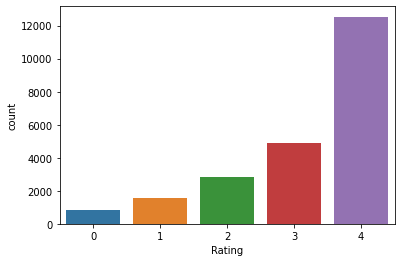

In [14]:
# Observar como está distribuido el dataset
sns.countplot(x='Rating', data=df_reviews)
plt.show()

Se puede observar que el dataset está bastante **desbalanceado**

### balanceado de dataset (oversampling)

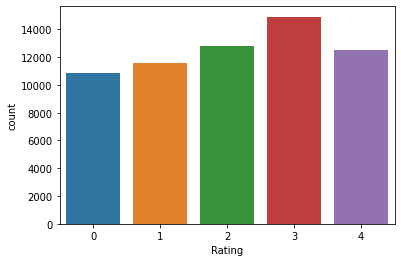

In [15]:
lst = [df_reviews]
for class_index, group in df_reviews.groupby('Rating'):
    if (class_index!=4):lst.append(group.sample(10000, replace=True))
frame_new = pd.concat(lst)

df_reviews = frame_new

sns.countplot(x='Rating', data=frame_new)
plt.show()


### Preprocesamiento de corpus

In [16]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(62641,)

In [17]:
# Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

62641

In [18]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [19]:
# ¿Cuál es la longitud de ese corpus?
len(corpus)

19804762

In [20]:
print(corpus[0:20])

Absolutely wonderful


In [21]:
# Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from torch_helpers import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [22]:
# Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [23]:
# ¿Cuántos tokens/palabras hay?
len(tokens)

3876596

In [24]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [25]:
# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [26]:
# Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [27]:
sequences[0][:10]

[312, 689, 1023, 3, 908, 3, 119]

In [28]:
# Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

### padding

In [29]:
# Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from torch_helpers import pad_sequences
maxlen = 115 + 1 #sumo 1 para mas padding

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [30]:
# Observar las dimensiones de la variable input
X.shape

(62641, 116)

In [31]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y"

y = df_reviews['Rating'].values
print(y.shape)

# luego transformada a oneHotEncoding
y = pd.get_dummies(y).values
print(y.shape)

# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)


(62641,)
(62641, 5)


### definicion dataset pytorch

In [32]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # la loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)


input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 116
Output dim 5


In [33]:
# Testeo funcionamiento de __getitem__
data_set[1]

(tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,   32,    7,   17,   35, 1362,   90,
            2,  962,    8,  263,    4,    9,    5,  126,    3,   37,  488,    2,
          122, 1046,    2,  410,   34,   23,   51,    4,  135, 1046,   35,  105,
            2,   93,    5,  105,    3,   40,  517,    2,   32,    1,   94,   12,
           26,  491,   33,    5,   70,  442,    1,  451,   34,  187,   27,    5,
          173, 1656,   12,  327,  385,    6,  792,  105], dtype=torch.int32),
 tensor([0., 0., 0., 0., 1.]))

### split en train y en test

In [34]:
# Dividir los datos en train y test
# Fijamos un "seed" constante para que siempre el dataset se parta de la misma 
# forma para poder repetir los ensayos

torch.manual_seed(42)
data_set_reduced_size = int(data_set.len * 0.4)

valid_set_size = int(data_set_reduced_size * 0.2)
train_set_size = data_set_reduced_size - valid_set_size

data_set_reduced, _ = torch.utils.data.random_split(data_set, [data_set_reduced_size, data_set.len - data_set_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_reduced, [train_set_size, data_set_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))





Tamaño del conjunto de entrenamiento: 20045
Tamaño del conjunto de validacion: 5011


### creacion de dataloader

In [35]:
batch_size=64

train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size, shuffle=True)

In [36]:
# Train dataloader
batch_1 = next(iter(train_loader))
print("Shape X train dataloader ", batch_1[0].shape, "----    Shape y train dataloader ", batch_1[1].shape)

Shape X train dataloader  torch.Size([64, 116]) ----    Shape y train dataloader  torch.Size([64, 5])


In [37]:
# Train dataloader
batch_1 = next(iter(valid_loader))
print("Shape X valid  dataloader ", batch_1[0].shape, "----    Shape y valid dataloader ", batch_1[1].shape)

Shape X valid  dataloader  torch.Size([64, 116]) ----    Shape y valid dataloader  torch.Size([64, 5])


### 2 - Entrenar el modelo con Embeddings + LSTM

In [46]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size + 1 para padding o UNK
        # embedding_dim = 50 --> crear embeddings de tamaño 50 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding_dim = 50
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=128) # Fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
#model1_criterion = torch.nn.BCELoss()  # Para clasificación binaria

model1_criterion = nn.CrossEntropyLoss()

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 5]                    --
├─Embedding: 1-1                         [1, 116, 50]              100,050
├─LSTM: 1-2                              [1, 116, 64]              62,976
├─Linear: 1-3                            [1, 128]                  8,320
├─ReLU: 1-4                              [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 5]                    645
Total params: 171,991
Trainable params: 171,991
Non-trainable params: 0
Total mult-adds (M): 7.41
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.69
Estimated Total Size (MB): 0.80

In [47]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        	
        iterator=iter(valid_loader)
        valid_data, valid_target = next(iterator)
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [48]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=40
                )




Epoch: 1/40 - Train loss 1.467 - Train accuracy 0.320 - Valid Loss 1.340 - Valid accuracy 0.422
Epoch: 2/40 - Train loss 1.221 - Train accuracy 0.445 - Valid Loss 1.253 - Valid accuracy 0.469
Epoch: 3/40 - Train loss 1.076 - Train accuracy 0.515 - Valid Loss 1.033 - Valid accuracy 0.578
Epoch: 4/40 - Train loss 0.975 - Train accuracy 0.566 - Valid Loss 0.913 - Valid accuracy 0.625
Epoch: 5/40 - Train loss 0.864 - Train accuracy 0.623 - Valid Loss 1.023 - Valid accuracy 0.594
Epoch: 6/40 - Train loss 0.769 - Train accuracy 0.670 - Valid Loss 0.694 - Valid accuracy 0.641
Epoch: 7/40 - Train loss 0.693 - Train accuracy 0.711 - Valid Loss 0.867 - Valid accuracy 0.656
Epoch: 8/40 - Train loss 0.617 - Train accuracy 0.749 - Valid Loss 0.769 - Valid accuracy 0.609
Epoch: 9/40 - Train loss 0.554 - Train accuracy 0.779 - Valid Loss 0.559 - Valid accuracy 0.812
Epoch: 10/40 - Train loss 0.496 - Train accuracy 0.806 - Valid Loss 0.706 - Valid accuracy 0.750
Epoch: 11/40 - Train loss 0.462 - Train

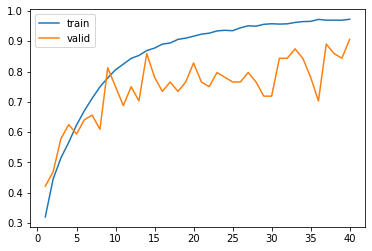

In [49]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

Conclusiones

Se puede observar que el modelo overfitea un poco aunque no demasiado.  Como estrategia a este comportamiento podría normalizarse el modelo o emplear embedings que ya hayan sido probados y curados como los de GloVe / FastText. Para evitar los saltos de loss, tambien podria userse un lerning rate menor y mas epochs. 

Sin embargo, puede verse que el modelo converge rápido y aprende bastante rápido también. con pocas epochs se alcanza un accuracy del 70% en validation. Por lo que la estrategia de LSTM brinda una notoria mejoría respecto a las estrategias tradicionales de Redes neuronales recurrentes. 